##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic classification: Classify particles as alpha, beta or quenched

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This guide trains a neural network model to classify particles as solid and liquid.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)

2.0.1


## Import the descriptor data

This network uses a combination of SOAP and symmetry adapted functions as descriptors.

Here, 32,400 descriptors are used to train the network and 10,800 descriptors to evaluate how accurately the network learned to classify particles.

In [5]:
train_data = np.load('train_soap+sym.npy')
train_labels = np.load('train_GeTe_labels.npy')
test_data = np.load('alpha_soap+sym.npy')
test_labels = np.load('alpha_GeTe_labels.npy')

Loading the dataset returns four NumPy arrays:

* The `train_data` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_data`, and `test_labels` arrays.

The data are 1D NumPy arrays with 551 components (545 SOAP, 6 symmetry adapted functions). The *labels* are an array of 3 integers, 0 for alpha, 1 for beta, 2 for quenched.

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>alpha</td>
  </tr>
  <tr>
    <td>1</td>
    <td>beta</td>
  </tr>
  <tr>
    <td>2</td>
    <td>quenched</td>
  </tr>    
</table>

Each particle is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when making plots later:

In [6]:
classification = ['ALpha','Beta','Quenched']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 32,400 descriptors, each with 551 components:

In [7]:
train_data.shape

(32400, 551)

Likewise, there are 10,800 labels in the training set:

In [8]:
len(train_labels)

32400

Each label is an integer, 0, 1 or 2:

In [9]:
train_labels

array([0, 0, 0, ..., 2, 2, 2])

There are 10,800 descriptors in the test set. Again, each descriptor has 551 components

In [10]:
test_data.shape

(10800, 551)

And the test set contains 10,800 labels:

In [11]:
len(test_labels)

10800

## Preprocess the data
No pre-processing was required for this classification.


## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [12]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu',input_shape=(len(train_data[0]),)),
    keras.layers.Dense(3, activation='softmax')
])

There was no need for flattening as the data was already a 1D array.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer is a 3-node *softmax* layer that returns an array of 3 probability scores that sum to 1. Each node contains a score that indicates the probability that the current particle belongs to one of the 3 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* *Optimizer* —This is how the model is updated based on the data it sees and its loss function.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the particles that are correctly classified.

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_data` and `train_labels` arrays.
2. The model learns to associate descriptors and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_data` array. Verify that the predictions match the labels from the `test_labels` array.

To start training,  call the `model.fit` method—so called because it "fits" the model to the training data:

In [14]:
start = time.time()
model.fit(train_data, train_labels, epochs=10)
end = time.time()
#print(end-start)

Train on 32400 samples
Epoch 1/10
32400/32400 [==============================] - 2s 70us/sample - loss: 0.1534 - accuracy: 0.9719
Epoch 2/10
32400/32400 [==============================] - 2s 50us/sample - loss: 0.0171 - accuracy: 0.9962
Epoch 3/10
32400/32400 [==============================] - 2s 50us/sample - loss: 0.0105 - accuracy: 0.9975
Epoch 4/10
32400/32400 [==============================] - 1s 45us/sample - loss: 0.0081 - accuracy: 0.9978
Epoch 5/10
32400/32400 [==============================] - 1s 43us/sample - loss: 0.0067 - accuracy: 0.9980
Epoch 6/10
32400/32400 [==============================] - 1s 43us/sample - loss: 0.0057 - accuracy: 0.9984
Epoch 7/10
32400/32400 [==============================] - 2s 48us/sample - loss: 0.0053 - accuracy: 0.9984
Epoch 8/10
32400/32400 [==============================] - 2s 47us/sample - loss: 0.0043 - accuracy: 0.9988
Epoch 9/10
32400/32400 [==============================] - 1s 44us/sample - loss: 0.0042 - accuracy: 0.9988
Epoch 10/10
32

As the model trains, the loss and accuracy metrics are displayed.

## Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [15]:
start = time.time()

test_loss, test_acc = model.evaluate(test_data,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

end = time.time()
#print(end-start)
model.save('Gete_classifier')

10800/1 - 0s - loss: 0.0027 - accuracy: 0.9994

Test accuracy: 0.9994444
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Gete_classifier/assets


In [16]:
model.save('GeTe_classifier_1.h5')

It turns out that the accuracy on the test dataset is roughly the same as the accuracy on the training dataset. If there was a gap between training accuracy and test accuracy, this would represent *overfitting*. Overfitting is when a machine learning model performs worse on new, previously unseen inputs than on the training data.

## Make predictions

With the model trained, you can use it to make predictions about some data.

In [17]:
start=time.time()
predictions = model.predict(test_data)
end = time.time()
print(end-start)

0.38915419578552246


In [18]:
a= predictions[:,0]

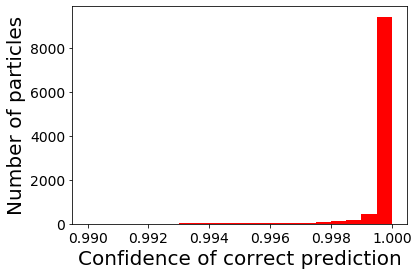

In [24]:
#Create confidence plots
plt.hist(a,bins=20, range=(0.99,1), color='red')
plt.xlabel('Confidence of correct prediction',fontsize=20)
plt.ylabel('Number of particles',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('quenchedconfidenceplot.png')
plt.show()

A prediction is an array of 3 numbers. They represent the model's "confidence" that the descriptor corresponds to each of the 3 states (alpha, beta, quenched). You can see which label has the highest confidence value:

In [25]:
predictions[0]

array([9.9994361e-01, 4.6249639e-05, 1.0090762e-05], dtype=float32)

In [26]:
np.argmax(predictions[0])

0

In [27]:
test_labels[0]

0